[AI해커톤 본선] Episode3 분석코드 (팀ID: aiplay1115)

# 0. 라이브러리 설치 및 AIDU 연동을 위한 설정

In [14]:
#Connect with AIDU with Centro Modules
from aicentro.session import Session
aidu_session = Session(verify=False)

from aicentro.framework.keras import Keras as AiduFrm
aidu_framework = AiduFrm(session=aidu_session)

#Import Base Module for Data Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import datetime
import os

from sklearn.model_selection import train_test_split
get_ipython().system('pip install xgboost')
import xgboost as xgb
from xgboost import plot_tree
import sklearn
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

# get_ipython().system('pip install seaborn')
import seaborn as sns

# get_ipython().system('pip install mglearn')
import mglearn

# get_ipython().system('pip install biokit')
from biokit.viz import corrplot

# get_ipython().system('pip install dcor')
import dcor

Looking in indexes: http://10.220.235.19/pypi/simple
You should consider upgrading via the 'pip install --upgrade pip' command.
Looking in indexes: http://10.220.235.19/pypi/simple
     |████████████████████████████████| 2.6MB 61.9MB/s eta 0:00:01█▏  | 2.3MB 61.9MB/s eta 0:00:01
     |████████████████████████████████| 18.3MB 60.5MB/s eta 0:00:01K     |██                              | 1.2MB 60.5MB/s eta 0:00:01��████████▊             | 10.7MB 60.5MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


# 1. 데이터 탐색 (EDA)

## 1-0. Data Loading
- **Table 1** : 사용자의 VOD 구매/시청 정보
- **Table 2** : VOD Type별 시청정보
- **Table 3** : VOD Type 정의서 

In [3]:
#--------------------------------------------------------------------
# Data loading
#--------------------------------------------------------------------
# Train data
train_t1 = pd.read_csv(aidu_framework.config.data_dir + '/ep3_train_t1.csv') #Table 1
train_t2 = pd.read_csv(aidu_framework.config.data_dir + '/ep3_train_t2.csv') #Table 2

# Test data
test_t1 = pd.read_csv(aidu_framework.config.data_dir + '/ep3_test_t1.csv') #Table 1
test_t2 = pd.read_csv(aidu_framework.config.data_dir + '/ep3_test_t2.csv') #Table 2

vod_type = pd.read_csv(aidu_framework.config.data_dir + '/ep3_vod_type.csv') # Table 3

# 데이터 크기 확인
print(train_t1.shape, train_t2.shape, test_t1.shape, test_t2.shape, vod_type.shape)

(30000, 65) (178136, 6) (10000, 64) (60743, 6) (259, 4)


## 1-1. 데이터 구성 및 결측 확인

In [4]:
train_t1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 65 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      30000 non-null  object 
 1   favor_genre             30000 non-null  object 
 2   tot_buy_noday           30000 non-null  int64  
 3   tot_buy_cascnt          30000 non-null  int64  
 4   tot_buy_amt             30000 non-null  int64  
 5   avg_buy_amt             30000 non-null  float64
 6   max_buy_amt             30000 non-null  int64  
 7   min_buy_amt             30000 non-null  int64  
 8   acton_sf_buy_cascnt     30000 non-null  int64  
 9   acton_sf_buy_amt        30000 non-null  int64  
 10  acton_sf_avg_buy_amt    30000 non-null  float64
 11  acton_sf_max_buy_amt    30000 non-null  int64  
 12  acton_sf_min_buy_amt    30000 non-null  int64  
 13  crim_thrl_buy_cascnt    30000 non-null  int64  
 14  crim_thrl_buy_amt       30000 non-null

In [5]:
train_t2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178136 entries, 0 to 178135
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              178136 non-null  object
 1   vod_type_cd     178136 non-null  int64 
 2   lvl_1_vod_type  178136 non-null  object
 3   lvl_2_vod_type  178136 non-null  object
 4   lvl_3_vod_type  178136 non-null  object
 5   view_cnt        178136 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 8.2+ MB


In [6]:
test_t1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 64 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      10000 non-null  object 
 1   tot_buy_noday           10000 non-null  int64  
 2   tot_buy_cascnt          10000 non-null  int64  
 3   tot_buy_amt             10000 non-null  int64  
 4   avg_buy_amt             10000 non-null  float64
 5   max_buy_amt             10000 non-null  int64  
 6   min_buy_amt             10000 non-null  int64  
 7   acton_sf_buy_cascnt     10000 non-null  int64  
 8   acton_sf_buy_amt        10000 non-null  int64  
 9   acton_sf_avg_buy_amt    10000 non-null  float64
 10  acton_sf_max_buy_amt    10000 non-null  int64  
 11  acton_sf_min_buy_amt    10000 non-null  int64  
 12  crim_thrl_buy_cascnt    10000 non-null  int64  
 13  crim_thrl_buy_amt       10000 non-null  int64  
 14  crim_thrl_avg_buy_amt   10000 non-null 

In [7]:
test_t2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60743 entries, 0 to 60742
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              60743 non-null  object
 1   vod_type_cd     60743 non-null  int64 
 2   lvl_1_vod_type  60743 non-null  object
 3   lvl_2_vod_type  60743 non-null  object
 4   lvl_3_vod_type  60743 non-null  object
 5   view_cnt        60743 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.8+ MB


In [8]:
# 결측치 여부 확인
print("Any missing sample in training set:",train_t1.isnull().values.any())
print("Any missing sample in training set:",train_t2.isnull().values.any())
print("Any missing sample in test set:",test_t1.isnull().values.any())
print("Any missing sample in test set:",test_t2.isnull().values.any(), "\n")

Any missing sample in training set: False
Any missing sample in training set: False
Any missing sample in test set: False
Any missing sample in test set: False 



In [9]:
# train t2에 대해서 ID가 각 30000으로 train_1과 동일
# train t1, t2를 ID 기준으로 결합해서 최종 dataset 생성
train_t2['id'].unique().shape

(30000,)

## 1-2. 선호 장르 분포 확인

In [10]:
# Frequency distribution of classes
train_outcome = pd.crosstab(index=train_t1["favor_genre"],  # Make a crosstab
                              columns="count")      # Name the count column
train_outcome

col_0,count
favor_genre,
ACTION_SF,3610
ANMT,3450
CHDR_FAMLY,3553
CMDY,3575
CRIM_THRL,3484
DOCU,1487
DRAMA,3478
HORR,3512
MTART,288


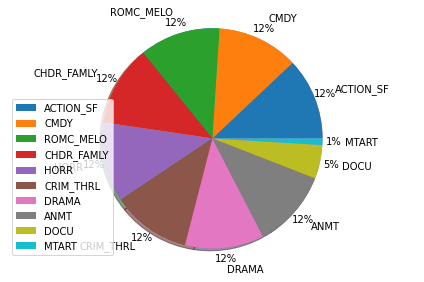

In [11]:
# Visualizing Outcome Distribution 
temp = train_t1["favor_genre"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })

labels = df['labels']
sizes = df['values']
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','cyan','lightpink']
patches, texts = plt.pie(sizes, shadow=True, startangle=90, pctdistance=1.1, labeldistance=1.2)
plt.pie(sizes, labels=labels, autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
plt.legend(patches, labels, loc="lower left")
plt.axis('equal')
plt.tight_layout()
plt.show()

## 1-3. 변수 상관분석 및 시각화

In [12]:
# 10개의 장르에 대한 구매건수 데이터 
df = pd.read_csv(aidu_framework.config.data_dir + '/ep3_train_t1.csv')
buy_cascnt_colnames = ['favor_genre'
, 'tot_buy_cascnt'
,'acton_sf_buy_cascnt'
,'crim_thrl_buy_cascnt'
,'drama_buy_cascnt'
,'romc_melo_buy_cascnt'
,'cmdy_buy_cascnt'
,'horr_buy_cascnt'
,'chdr_famly_buy_cascnt'
,'docu_buy_cascnt'
,'mtart_buy_cascnt'
,'anmt_buy_cascnt'
]
df_buy = df[buy_cascnt_colnames]

,favor_genre,tot_buy_cascnt,acton_sf_buy_cascnt,crim_thrl_buy_cascnt,drama_buy_cascnt,romc_melo_buy_cascnt,cmdy_buy_cascnt,horr_buy_cascnt,chdr_famly_buy_cascnt,docu_buy_cascnt,mtart_buy_cascnt,anmt_buy_cascnt
0,ACTION_SF,1,0,0,0,1,0,0,0,0,0,0
1,CRIM_THRL,1,0,0,1,0,0,0,0,0,0,0
2,ANMT,1,0,0,0,0,0,0,1,0,0,0
3,ANMT,1,0,0,1,0,0,0,0,0,0,0
4,ANMT,5,0,1,1,0,0,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
29995,CHDR_FAMLY,5,4,0,0,0,0,0,1,0,0,0
29996,MTART,1,1,0,0,0,0,0,0,0,0,0
29997,CRIM_THRL,3,0,1,0,1,0,1,0,0,0,0
29998,DOCU,1,0,0,1,0,0,0,0,0,0,0


### 1-3-1. 선호 장르에 따른 장르별 구매건수의 Pair Plot

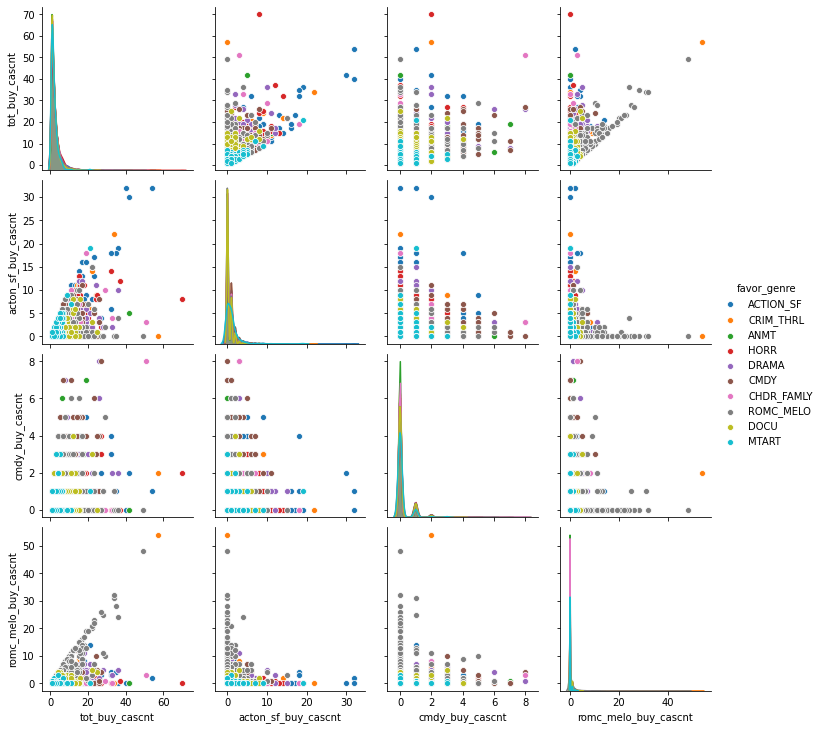

In [14]:
# count 기반 top3 설정하기
buy_cascnt_colnames_plot1 = ['favor_genre'
, 'tot_buy_cascnt'
,'acton_sf_buy_cascnt'
,'cmdy_buy_cascnt'
,'romc_melo_buy_cascnt'
]
sns.pairplot(df_buy[buy_cascnt_colnames_plot1]
             , hue='favor_genre');
plt.show()

### 1-3-2. 장르별 구매건수의 Pearson Correlation

/usr/local/lib/python3.6/dist-packages/biokit/viz/corrplot.py:402: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=False)
/usr/local/lib/python3.6/dist-packages/biokit/viz/corrplot.py:335: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
  cb.set_clim(0,1) # make sure it goes from -1 to 1 even though actual values may not reach that range


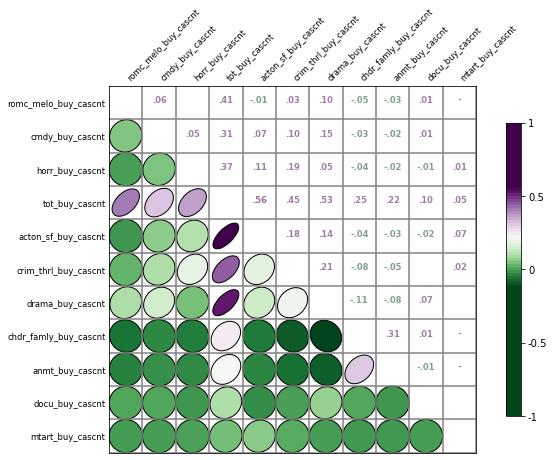

In [16]:
# get_ipython().system('pip install biokit')
from biokit.viz import corrplot

## Pearson Correlation 구하고 시각화하기
# df_buy:장르별 구매 변수들에 대한 data frame
corr = df_buy.corr(method='pearson')
c = corrplot.Corrplot(corr)
c.plot(method='ellipse', cmap='PRGn_r'
       , shrink=1, rotation=45
       , upper='text', lower='ellipse')
fig = plt.gcf()
fig.set_size_inches(10, 8);

### 1-3-3. 장르별 구매건수의 Distance Correlation Plot

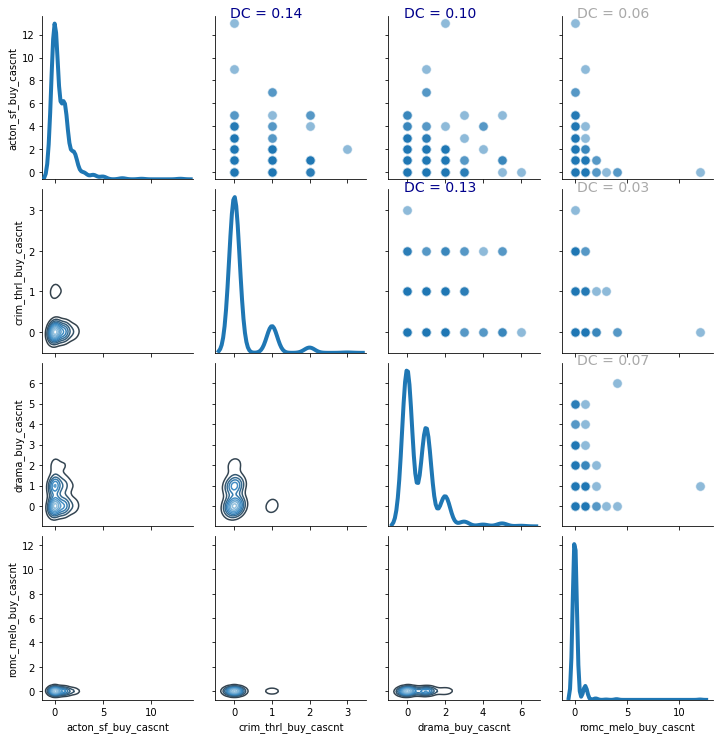

In [21]:
## 함수 만들기
def dist_corr(X, Y, pval=True, nruns=2000):
	#Distance correlation with p-value from bootstrapping
	dc = dcor.distance_correlation(X, Y)
	pv = dcor.independence.distance_covariance_test(X, Y, 
                                                    exponent=1.0, num_resamples=nruns)[0]
	if pval:
	    return (dc, pv)
	else:
	    return dc

## corrfunc
def corrfunc(x, y, **kws):
	d, p = dist_corr(x,y) 
	#print("{:.4f}".format(d), "{:.4f}".format(p))
	if p > 0.1:
	    pclr = 'Darkgray'
	else:
	    pclr= 'Darkblue'
	ax = plt.gca()
	ax.annotate("DC = {:.2f}".format(d), xy=(.1, 0.99), 
                xycoords=ax.transAxes, color = pclr, fontsize = 14)

buy_cascnt_colnames2 = [
'acton_sf_buy_cascnt'
,'crim_thrl_buy_cascnt'
,'drama_buy_cascnt'
,'romc_melo_buy_cascnt'
# ,'cmdy_buy_cascnt'

]
buy_cascnt_colnames2

# 데이터 로딩
df_buy2 = df[buy_cascnt_colnames2]

df_buy2=df_buy2.sample(500)
g = sns.PairGrid(df_buy2, diag_sharey=False)
axes = g.axes
g.map_upper(plt.scatter, linewidths=1
            , edgecolor="w", s=90, alpha = 0.5)
g.map_upper(corrfunc)
g.map_diag(sns.kdeplot, lw = 4, legend=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
plt.show()

# 2. 데이터 전처리

## 2-1. Table 2 구조 변환

In [22]:
# 사람별 VOD Type별 시청건수 테이블 생성 
train_t2_r = train_t2.groupby(['id','vod_type_cd'])['view_cnt'].sum().reset_index()
train_t2_r

,id,vod_type_cd,view_cnt
0,E3000001,10600,1
1,E3000001,41000,11
2,E3000002,10500,6
3,E3000003,11600,2
4,E3000003,20400,2
...,...,...,...
178131,E3030080,30500,6
178132,E3030081,10500,2
178133,E3030081,41000,33
178134,E3030081,50000,2


In [23]:
train_t2_r['vod_type_cd'] = ['vod_'+str(cd) for cd in train_t2_r['vod_type_cd']] #VOD 코드 값 수정 
train_t2_r = train_t2_r.pivot(index='id', columns='vod_type_cd', values='view_cnt') #VOD Type을 컬럼으로 변환
train_t2_r.fillna(0, inplace=True) #결측치 => 0
print(train_t2_r.shape)
train_t2_r

(30000, 205)


vod_type_cd,vod_10000,vod_100000,vod_100100,vod_100101,vod_100200,vod_100201,vod_100203,vod_100204,vod_100205,vod_100206,...,vod_90300,vod_90500,vod_90600,vod_90700,vod_91000,vod_91100,vod_91200,vod_91300,vod_91400,vod_91500
id,,,,,,,,,,,,,,,,,,,,,
E3000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E3000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E3000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E3000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E3000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E3030077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E3030078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E3030079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# 마찬가지로 Test set 에 대해 동일하게 구조 변환 
test_t2_r = test_t2.groupby(['id','vod_type_cd'])['view_cnt'].sum().reset_index()
test_t2_r['vod_type_cd'] = ['vod_'+str(cd) for cd in test_t2_r['vod_type_cd']] #VOD 코드 값 수정 
test_t2_r = test_t2_r.pivot(index='id', columns='vod_type_cd', values='view_cnt') #VOD Type을 컬럼으로 변환
test_t2_r.fillna(0, inplace=True) #결측치 => 0
print(test_t2_r.shape)

(10000, 192)


In [25]:
# test set의 vod type을  train set에 포함된 vod type으로 맞춤  
diff_cols_train = set(train_t2_r.columns) - set(test_t2_r.columns) #test에 0으로 추가
diff_cols_test = set(test_t2_r.columns) - set(train_t2_r.columns) #test에서 버림
print(len(diff_cols_train), len(diff_cols_test))
for col in diff_cols_train:
    test_t2_r[col] = 0.0
test_t2_r.drop(diff_cols_test, axis=1,inplace=True)
print(test_t2_r.shape)

len(set(train_t2_r.columns) & set(test_t2_r.columns)) #T2 최종 컬럼 수 (vod type개수)

19 6
(10000, 205)


205

In [26]:
# Table1, Table2 merge

# train
print(train_t1.shape, train_t2_r.shape , train_t1.shape[1] + train_t2_r.shape[1])
train_t2_r.reset_index(level=0, inplace=True)
train_t3 = train_t1.merge(train_t2_r, on='id')
print("== Final Train shape:",train_t3.shape,'\n')

# test
print(test_t1.shape, test_t2_r.shape , test_t1.shape[1] + test_t2_r.shape[1])
test_t2_r.reset_index(level=0, inplace=True)
test_t3 = test_t1.merge(test_t2_r, on='id')
print("== Final Test shape:",test_t3.shape,'\n')

(30000, 65) (30000, 205) 270
== Final Train shape: (30000, 270) 

(10000, 64) (10000, 205) 269
== Final Test shape: (10000, 269) 



#### 위 과정을 통해 생성된 데이터 (Table 3) 저장 

In [ ]:
# train_t3.to_csv(aidu_framework.config.data_dir + '/ep3_train_t3.csv', index=False)
# test_t3.to_csv(aidu_framework.config.data_dir + '/ep3_test_t3.csv', index=False)

## 2-2. VOD Type Level에 따른 변수 생성

#### VOD Type Level 1

In [27]:
#생성 변수 리스트 
type_lv1 = pd.DataFrame({(i,_) for i,_ in enumerate(train_t2.lvl_1_vod_type.unique())}, columns=['vtype','lvl_1_vod_type'])
for i,_ in type_lv1.iterrows():
    type_lv1.loc[i,'variable'] = 'vod_lv1_'+str(_.vtype)
type_lv1 = type_lv1.sort_values('vtype').reset_index(drop=True)
type_lv1.drop('vtype',1)
# type_lv1.drop('vtype',1).to_csv(aidu_framework.config.data_dir + '/type_lv1.csv',index=False)

,lvl_1_vod_type,variable
0,애니시리즈,vod_lv1_0
1,실사영화,vod_lv1_1
2,애니영화,vod_lv1_2
3,TV시리즈,vod_lv1_3
4,음악,vod_lv1_4
5,TV연예/오락,vod_lv1_5
6,시사교양,vod_lv1_6
7,성인,vod_lv1_7
8,기타,vod_lv1_8
9,라이프스타일,vod_lv1_9


In [28]:
### Train set에 대해 변수 생성
train_t2_r1 = train_t2.groupby(['id','lvl_1_vod_type'])['view_cnt'].sum().reset_index()
train_t2_r1 = train_t2_r1.merge(type_lv1, on='lvl_1_vod_type', how='left')
train_t2_r1['vod_type_cd'] = ['vod_lv1_'+str(cd) for cd in train_t2_r1['vtype']] #VOD 코드 값 수정 
train_t2_r1 = train_t2_r1.pivot(index='id', columns='vod_type_cd', values='view_cnt') #VOD 코드를 컬럼으로 변환 
train_t2_r1.fillna(0, inplace=True) #결측치 => 0
train_t2_r1.reset_index(level=0, inplace=True)

train_t4 = train_t3.merge(train_t2_r1, on='id') # Table3와 Merge
train_t4

,id,favor_genre,tot_buy_noday,tot_buy_cascnt,tot_buy_amt,avg_buy_amt,max_buy_amt,min_buy_amt,acton_sf_buy_cascnt,acton_sf_buy_amt,...,vod_lv1_12,vod_lv1_13,vod_lv1_2,vod_lv1_3,vod_lv1_4,vod_lv1_5,vod_lv1_6,vod_lv1_7,vod_lv1_8,vod_lv1_9
0,E3000001,ACTION_SF,1,1,2500,2500.0,2500,2500,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,E3000002,CRIM_THRL,1,1,7000,7000.0,7000,7000,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,E3000003,ANMT,1,1,2500,2500.0,2500,2500,0,0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,E3000004,ANMT,1,1,1400,1400.0,1400,1400,0,0,...,0.0,0.0,3.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0
4,E3000005,ANMT,3,5,12100,2420.0,6500,1400,0,0,...,0.0,0.0,3.0,0.0,87.0,3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,E3030077,CHDR_FAMLY,5,5,12500,2500.0,2500,2500,4,10000,...,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29996,E3030078,MTART,1,1,10000,10000.0,10000,10000,1,10000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29997,E3030079,CRIM_THRL,3,3,4200,1400.0,1400,1400,0,0,...,0.0,0.0,0.0,2.0,0.0,11.0,1.0,0.0,0.0,0.0
29998,E3030080,DOCU,1,1,1400,1400.0,1400,1400,0,0,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
### Test set에 대해 변수 생성
test_t2_r1 = test_t2.groupby(['id','lvl_1_vod_type'])['view_cnt'].sum().reset_index()
test_t2_r1 = test_t2_r1.merge(type_lv1, on='lvl_1_vod_type', how='left')
test_t2_r1['vod_type_cd'] = ['vod_lv1_'+str(cd) for cd in test_t2_r1['vtype']] #VOD 코드 값 수정 
test_t2_r1 = test_t2_r1.pivot(index='id', columns='vod_type_cd', values='view_cnt') #VOD 코드를 컬럼으로 변환 
test_t2_r1.fillna(0, inplace=True) #결측치 => 0
test_t2_r1.reset_index(level=0, inplace=True)
test_t2_r1

# Train set과 동일하게 변수 맞춤 
only_train = set(train_t2_r1.columns) - set(test_t2_r1.columns)
for c in only_train:
    test_t2_r1[c]=0
only_test = set(test_t2_r1.columns) - set(train_t2_r1.columns)
test_t2_r1=test_t2_r1.drop(only_test,axis=1)

test_t4 = test_t3.merge(test_t2_r1, on='id') # Table3와 Merge
test_t4

,id,tot_buy_noday,tot_buy_cascnt,tot_buy_amt,avg_buy_amt,max_buy_amt,min_buy_amt,acton_sf_buy_cascnt,acton_sf_buy_amt,acton_sf_avg_buy_amt,...,vod_lv1_12,vod_lv1_2,vod_lv1_3,vod_lv1_4,vod_lv1_5,vod_lv1_6,vod_lv1_7,vod_lv1_8,vod_lv1_9,vod_lv1_13
0,E3030346,2,2,5000,2500.000000,2500,2500,0,0,0.000000,...,0.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0
1,E3030347,1,1,2500,2500.000000,2500,2500,1,2500,2500.000000,...,0.0,2.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0
2,E3030348,2,2,12500,6250.000000,10000,2500,0,0,0.000000,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0
3,E3030349,1,1,6500,6500.000000,6500,6500,1,6500,6500.000000,...,0.0,0.0,86.0,0.0,9.0,0.0,0.0,0.0,0.0,0
4,E3030350,2,2,17000,8500.000000,10000,7000,2,17000,8500.000000,...,0.0,1.0,140.0,7.0,53.0,27.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,E3040365,1,1,10000,10000.000000,10000,10000,1,10000,10000.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9996,E3040366,1,1,5000,5000.000000,5000,5000,1,5000,5000.000000,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0
9997,E3040367,9,9,38900,4322.222222,10000,1400,2,11400,5700.000000,...,0.0,0.0,0.0,169.0,6.0,0.0,0.0,0.0,1.0,0
9998,E3040368,1,1,5000,5000.000000,5000,5000,0,0,0.000000,...,0.0,0.0,13.0,0.0,2.0,0.0,0.0,0.0,0.0,0


#### VOD Type Level 2

In [30]:
#생성 변수 리스트 
type_lv2 = pd.DataFrame({(i,_) for i,_ in enumerate(train_t2.lvl_2_vod_type.unique())}, columns=['vtype','lvl_2_vod_type'])
for i,_ in type_lv2.iterrows():
    type_lv2.loc[i,'variable'] = 'vod_lv2_'+str(_.vtype)
type_lv2 = type_lv2.sort_values('vtype').reset_index(drop=True)
type_lv2.drop('vtype',1)  
# type_lv2.drop('vtype',1).to_csv(aidu_framework.config.data_dir + '/type_lv2.csv',index=False)

,lvl_2_vod_type,variable
0,범죄/추리,vod_lv2_0
1,로맨스,vod_lv2_1
2,드라마,vod_lv2_2
3,휴먼/가족,vod_lv2_3
4,유아/어린이,vod_lv2_4
...,...,...
78,리얼리티,vod_lv2_78
79,교육정보,vod_lv2_79
80,농구,vod_lv2_80
81,토론,vod_lv2_81


In [31]:
### Train set에 대해 변수 생성
train_t2_r2 = train_t2.groupby(['id','lvl_2_vod_type'])['view_cnt'].sum().reset_index()
train_t2_r2 = train_t2_r2.merge(type_lv2, on='lvl_2_vod_type', how='left')
train_t2_r2['vod_type_cd'] = ['vod_lv2_'+str(cd) for cd in train_t2_r2['vtype']] #VOD 코드 값 수정 
train_t2_r2 = train_t2_r2.pivot(index='id', columns='vod_type_cd', values='view_cnt') #VOD 코드를 컬럼으로 변환 
train_t2_r2.fillna(0, inplace=True) #결측치 => 0
train_t2_r2.reset_index(level=0, inplace=True)

train_t4 = train_t4.merge(train_t2_r2, on='id') # 이전 데이터와 Merge
train_t4

,id,favor_genre,tot_buy_noday,tot_buy_cascnt,tot_buy_amt,avg_buy_amt,max_buy_amt,min_buy_amt,acton_sf_buy_cascnt,acton_sf_buy_amt,...,vod_lv2_75,vod_lv2_76,vod_lv2_77,vod_lv2_78,vod_lv2_79,vod_lv2_8,vod_lv2_80,vod_lv2_81,vod_lv2_82,vod_lv2_9
0,E3000001,ACTION_SF,1,1,2500,2500.0,2500,2500,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,E3000002,CRIM_THRL,1,1,7000,7000.0,7000,7000,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,E3000003,ANMT,1,1,2500,2500.0,2500,2500,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,E3000004,ANMT,1,1,1400,1400.0,1400,1400,0,0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
4,E3000005,ANMT,3,5,12100,2420.0,6500,1400,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,E3030077,CHDR_FAMLY,5,5,12500,2500.0,2500,2500,4,10000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29996,E3030078,MTART,1,1,10000,10000.0,10000,10000,1,10000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29997,E3030079,CRIM_THRL,3,3,4200,1400.0,1400,1400,0,0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
29998,E3030080,DOCU,1,1,1400,1400.0,1400,1400,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
### Test set에 대해 변수 생성
test_t2_r2 = test_t2.groupby(['id','lvl_2_vod_type'])['view_cnt'].sum().reset_index()
test_t2_r2 = test_t2_r2.merge(type_lv2, on='lvl_2_vod_type', how='left')
test_t2_r2['vod_type_cd'] = ['vod_lv2_'+str(cd) for cd in test_t2_r2['vtype']] #VOD 코드 값 수정 
test_t2_r2['vod_type_cd'] = [_[:-2] for _ in test_t2_r2.vod_type_cd]
test_t2_r2 = test_t2_r2.pivot(index='id', columns='vod_type_cd', values='view_cnt') #VOD 코드를 컬럼으로 변환 
test_t2_r2.fillna(0, inplace=True) #결측치 => 0
test_t2_r2.reset_index(level=0, inplace=True)
test_t2_r2

# Train set 과 동일하게 변수 맞춤 
only_train = set(train_t2_r2.columns) - set(test_t2_r2.columns)
for c in only_train:
    test_t2_r2[c]=0
only_test = set(test_t2_r2.columns) - set(train_t2_r2.columns)
test_t2_r2=test_t2_r2.drop(only_test,axis=1)

test_t4 = test_t4.merge(test_t2_r2, on='id') # 이전 데이터와 Merge
test_t4

,id,tot_buy_noday,tot_buy_cascnt,tot_buy_amt,avg_buy_amt,max_buy_amt,min_buy_amt,acton_sf_buy_cascnt,acton_sf_buy_amt,acton_sf_avg_buy_amt,...,vod_lv2_8,vod_lv2_80,vod_lv2_82,vod_lv2_9,vod_lv2_81,vod_lv2_70,vod_lv2_75,vod_lv2_76,vod_lv2_69,vod_lv2_61
0,E3030346,2,2,5000,2500.000000,2500,2500,0,0,0.000000,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
1,E3030347,1,1,2500,2500.000000,2500,2500,1,2500,2500.000000,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
2,E3030348,2,2,12500,6250.000000,10000,2500,0,0,0.000000,...,2.0,0.0,0.0,0.0,0,0,0,0,0,0
3,E3030349,1,1,6500,6500.000000,6500,6500,1,6500,6500.000000,...,6.0,0.0,0.0,0.0,0,0,0,0,0,0
4,E3030350,2,2,17000,8500.000000,10000,7000,2,17000,8500.000000,...,35.0,0.0,0.0,7.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,E3040365,1,1,10000,10000.000000,10000,10000,1,10000,10000.000000,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
9996,E3040366,1,1,5000,5000.000000,5000,5000,1,5000,5000.000000,...,2.0,0.0,0.0,0.0,0,0,0,0,0,0
9997,E3040367,9,9,38900,4322.222222,10000,1400,2,11400,5700.000000,...,5.0,0.0,0.0,164.0,0,0,0,0,0,0
9998,E3040368,1,1,5000,5000.000000,5000,5000,0,0,0.000000,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0


#### 위 과정을 통해 생성된 데이터 (Table 4) 저장 

In [ ]:
#train_t4.to_csv(aidu_framework.config.data_dir + '/ep3_train_t4.csv',index=False)
#test_t4.to_csv(aidu_framework.config.data_dir + '/ep3_test_t4.csv',index=False)

## 2-3. VOD Type Grouping을 통한 변수 생성

In [33]:
# VOD Type을 확인하여 의미 유사성에 따라 Grouping
# Grouping한 항목에 대해 사람별 시청건수를 저장 

###################################################
# VOD Type (vod_type_cd)를 다음과 같이 Grouping
###################################################
#종교시청시간
relig_vuing_id = [
140400,
140401,
140402,
140403
]

# 공공시청시간
pub_vuing_id = [
140000,
140100,
140200,
140300]


movie_sers_vuing_id = [
10000,
10100,
10200,
10300,
10400,
10500,
10600,
10700,
10800,
10900,
11000,
11100,
11200,
11300,
11400,
11500,
11600,
11700,
11800,
11900,
12000,
12100,
12200,
12300,
12400,
12500,
12600,
30000,
30100,
30200,
30300,
30400,
30500,
30600,
30700,
30800,
30900,
31000,
31100,
31200,
31300,
31400,
31500,
31600,
31601,
31602,
31603,
31604,
31605,
31606,
31607,
31608,
31609,
31610,
31611,
31612,
31613,
31700,
31800,
31900,
32000,
32100,
32200,
32300,
32400,
32500]



#애니메이션시청시간
anmt_vuing_id = [
20000,
20100,
20200,
20300,
20400,
20500,
20600,
20700,
20800,
20900,
21000,
21100,
21200,
21300,
21400,
21500,
21600,
21700,
21800,
21900,
22000,
22100,
22200,
22300,
22400,
22500,
22600,
40000,
40100,
40200,
40300,
40400,
40500,
40600,
40700,
40800,
40900,
41000,
41100,
41200,
41300,
41400,
41500,
41600,
41601,
41602,
41603,
41604,
41605,
41606,
41607,
41608,
41609,
41610,
41611,
41612,
41613,
41700,
41800,
41900,
42000,
42100,
42200,
42300,
42400,
42500]

# 액션/SF
action_sf_vuing_id =[
10100,
10200,
10300,
11700,
12400,
11300,
20100,
20200,
20300,
21700,
22400,
21300,
30100,
30200,
30300,
31700,
32400,
31300,
40100,
40200,
40300,
41700,
42400,
41300]


#호러
horr_vuing_id=[
10800,
20800,
30800,
40800]


#공포/스릴러
crim_thrl_vuing_id=[
11000,
12200,
21000,
22200,
31000,
32200,
41000,
42200
]


# 가족
chdr_famly_vuing_id =[
10400,
20400,
30400,
40400
]


# 어린이
child_vuing_id = [
41600,
41601,
41602,
41603,
41604,
41605,
41606,
41607,
41608,
41609,
41610,
41611,
41612,
41613,
31600,
31601,
31602,
31603,
31604,
31605,
31606,
31607,
31608,
31609,
31610,
31611,
31612,
31613,
21600,
11600,
12300,
22300,
32300,
42300]


# 드라마
drama_vuing_id = [
10500,
20500,
30500,
40500,
11800,
21800,
31800,
41800]

# 다큐
docu_vuing_id =[
11400,
21400,
31400,
41400
]


# 코메디
cmdy_vuing_id =[
10700,
20700,
30700,
40700
]

# 로멘스
romc_melo_vuing_id =[
10600,
20600,
30600,
40600,
11500,
21500,
31500,
41500
]

# 유아 애니메이션
anmt_child_vuing_id= [
21600,
41600,
41601,
41602,
41603,
41604,
41605,
41606,
41607,
41608,
41609,
41610,
41611,
41612,
41613
]

# 무협
mtart_vuing_id =[
10900,
11100,
11200,
20900,
21100,
21200,
30900,
31100,
31200,
40900,
41100,
41200]

# 기타
etc_vuing_id = [
10000,
11900,
12000,
12100,
12500,
12600,
20000,
21900,
22000,
22100,
22500,
22600,
30000,
31900,
32000,
32100,
32500,
40000,
41900,
42000,
42100,
42500
]

In [34]:
#생성 변수 리스트 

vars=[
pub_vuing_id
,movie_sers_vuing_id
,anmt_vuing_id
,action_sf_vuing_id
,horr_vuing_id
,crim_thrl_vuing_id
,chdr_famly_vuing_id
,child_vuing_id
,drama_vuing_id
,docu_vuing_id
,cmdy_vuing_id
,romc_melo_vuing_id
,anmt_child_vuing_id
,mtart_vuing_id
,etc_vuing_id] 

#  ('v0', 'relig_vuing_id'),
#  ('v1', 'pub_vuing_id'),
#  ('v2', 'movie_sers_vuing_id'),
#  ('v3', 'anmt_vuing_id'),
#  ('v4', 'action_sf_vuing_id'),
#  ('v5', 'horr_vuing_id'),
#  ('v6', 'crim_thrl_vuing_id'),
#  ('v7', 'chdr_famly_vuing_id'),
#  ('v8', 'child_vuing_id'),
#  ('v9', 'drama_vuing_id'),
#  ('v10', 'docu_vuing_id'),
#  ('v11', 'cmdy_vuing_id'),
#  ('v12', 'romc_melo_vuing_id'),
#  ('v13', 'anmt_child_vuing_id'),
#  ('v14', 'mtart_vuing_id'),
#  ('v15', 'etc_vuing_id')

In [35]:
#### Train set에 대해 변수 생성
df0 = train_t2.copy()

df = pd.DataFrame({'id':df0.id.unique()})
sub = df0[df0.vod_type_cd.isin(relig_vuing_id)]
sub2 = sub.groupby(['id'])['view_cnt'].sum().reset_index()
df2 =df.merge(sub2, on=['id'],how='left')

for v in vars:
    sub = df0[df0.vod_type_cd.isin(v)]
    sub2 = sub.groupby(['id'])['view_cnt'].sum().reset_index()
    df2=df2.merge(sub2, on=['id'],how='left')
    
df2.fillna(0, inplace=True)
s = ['v'+str(i) for i in range(16)]
df2.columns = ['id']+s


train_t5 = train_t4.merge(df2, on='id',how='left') # 이전 데이터와 Merge
train_t5

,id,favor_genre,tot_buy_noday,tot_buy_cascnt,tot_buy_amt,avg_buy_amt,max_buy_amt,min_buy_amt,acton_sf_buy_cascnt,acton_sf_buy_amt,...,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15
0,E3000001,ACTION_SF,1,1,2500,2500.0,2500,2500,0,0,...,11.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,E3000002,CRIM_THRL,1,1,7000,7000.0,7000,7000,0,0,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
2,E3000003,ANMT,1,1,2500,2500.0,2500,2500,0,0,...,0.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,E3000004,ANMT,1,1,1400,1400.0,1400,1400,0,0,...,0.0,3.0,1185.0,2.0,0.0,52.0,0.0,1140.0,0.0,3.0
4,E3000005,ANMT,3,5,12100,2420.0,6500,1400,0,0,...,3.0,3.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,E3030077,CHDR_FAMLY,5,5,12500,2500.0,2500,2500,4,10000,...,0.0,8.0,6.0,10.0,0.0,0.0,62.0,6.0,0.0,31.0
29996,E3030078,MTART,1,1,10000,10000.0,10000,10000,1,10000,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29997,E3030079,CRIM_THRL,3,3,4200,1400.0,1400,1400,0,0,...,3.0,0.0,0.0,9.0,0.0,1.0,5.0,0.0,0.0,0.0
29998,E3030080,DOCU,1,1,1400,1400.0,1400,1400,0,0,...,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
#### Test set에 대해 변수 생성
df0 = test_t2.copy()

df = pd.DataFrame({'id':df0.id.unique()})
sub = df0[df0.vod_type_cd.isin(relig_vuing_id)]
sub2 = sub.groupby(['id'])['view_cnt'].sum().reset_index()
df2 =df.merge(sub2, on=['id'],how='left')

for v in vars:
    sub = df0[df0.vod_type_cd.isin(v)]
    sub2 = sub.groupby(['id'])['view_cnt'].sum().reset_index()
    df2=df2.merge(sub2, on=['id'],how='left')
    
df2.fillna(0, inplace=True)
s = ['v'+str(i) for i in range(16)]
df2.columns = ['id']+s


test_t5=test_t4.merge(df2, on='id',how='left') # 이전 데이터와 Merge
test_t5

,id,tot_buy_noday,tot_buy_cascnt,tot_buy_amt,avg_buy_amt,max_buy_amt,min_buy_amt,acton_sf_buy_cascnt,acton_sf_buy_amt,acton_sf_avg_buy_amt,...,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15
0,E3030346,2,2,5000,2500.000000,2500,2500,0,0,0.000000,...,5.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1,E3030347,1,1,2500,2500.000000,2500,2500,1,2500,2500.000000,...,0.0,2.0,34.0,0.0,0.0,0.0,0.0,34.0,0.0,0.0
2,E3030348,2,2,12500,6250.000000,10000,2500,0,0,0.000000,...,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,E3030349,1,1,6500,6500.000000,6500,6500,1,6500,6500.000000,...,1.0,0.0,0.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0
4,E3030350,2,2,17000,8500.000000,10000,7000,2,17000,8500.000000,...,9.0,1.0,0.0,141.0,0.0,16.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,E3040365,1,1,10000,10000.000000,10000,10000,1,10000,10000.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,E3040366,1,1,5000,5000.000000,5000,5000,1,5000,5000.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,E3040367,9,9,38900,4322.222222,10000,1400,2,11400,5700.000000,...,3.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0
9998,E3040368,1,1,5000,5000.000000,5000,5000,0,0,0.000000,...,1.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0


### 위 과정을 통해 생성된 데이터 (Table 5) 저장

In [ ]:
# train_t5.to_csv(aidu_framework.config.data_dir + '/ep3_train_t5.csv',index=False)
# test_t5.to_csv(aidu_framework.config.data_dir + '/ep3_test_t5.csv',index=False)

## 2-4. X, y 데이터 분리 

In [48]:
# Data loading
train = pd.read_csv(aidu_framework.config.data_dir + '/ep3_train_t5.csv')
test = pd.read_csv(aidu_framework.config.data_dir + '/ep3_test_t5.csv')
train.shape, test.shape

((30000, 383), (10000, 382))

In [49]:
# Explain / Target variable 분리 
train_x = train.drop(['id','favor_genre'], axis=1)
train_y = train[['favor_genre']]
print('== Raw Train set size:', train_x.shape, train_y.shape)

test_x = test.drop(['id'], axis=1)
print('== Raw Test set size:', test_x.shape)

== Raw Train set size: (30000, 381) (30000, 1)
== Raw Test set size: (10000, 381)


## 2-5. Data Scaling & Encoding  

In [50]:
### Preprocessing
train_x_cate = train_x[['sex_cd','age_cd']]
train_x_num = train_x.drop(['sex_cd','age_cd'], axis=1)
train_x_dumm = pd.get_dummies(train_x_cate)

test_x_cate = test_x[['sex_cd','age_cd']]
test_x_num = test_x.drop(['sex_cd','age_cd'], axis=1)
test_x_dumm = pd.get_dummies(test_x_cate)

# Scaling the Train and Test feature set 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_x_scaled = pd.DataFrame(data=scaler.fit_transform(train_x_num),
                              columns=train_x_num.columns)
test_x_scaled = pd.DataFrame(data=scaler.transform(test_x_num),
                              columns=test_x_num.columns)

train_x_r = pd.concat([train_x_scaled, train_x_dumm], axis=1) #Scaling
# train_x_r = pd.concat([train_x_num, train_x_dumm], axis=1) #Non-scaling
print("== Processed Train X shape: : ", train_x_r.shape)

test_x_r = pd.concat([test_x_scaled, test_x_dumm], axis=1) #Scaling
# test_x_r = pd.concat([test_x_num, test_x_dumm], axis=1) #Non-scaling 
print("== Processed Test X shape: : ", test_x_r.shape)


Y_train_label = train_y.values.astype(object).ravel()
from sklearn import preprocessing
e = preprocessing.LabelEncoder()
e.fit(Y_train_label)
train_y_enc = e.transform(Y_train_label)
print("== Processed Train Y shape: : ", train_y_enc.shape)

e_name_mapping = dict(zip(e.classes_, e.transform(e.classes_)))
print('== Y Lable mapping:',e_name_mapping)

== Processed Train X shape: :  (30000, 400)
== Processed Test X shape: :  (10000, 400)
== Processed Train Y shape: :  (30000,)
== Y Lable mapping: {'ACTION_SF': 0, 'ANMT': 1, 'CHDR_FAMLY': 2, 'CMDY': 3, 'CRIM_THRL': 4, 'DOCU': 5, 'DRAMA': 6, 'HORR': 7, 'MTART': 8, 'ROMC_MELO': 9}


## 2-6. PCA를 이용한 차원 축소

In [51]:
import pandas as pd
from sklearn.decomposition import PCA

num = 100 #PCA dimension
pca = PCA(n_components=num)
pca.fit(train_x_scaled)

pca_train = pca.transform(train_x_scaled)
print(pca_train.shape)
pca_test = pca.transform(test_x_scaled)
print(pca_test.shape)

df_pca_train = pd.DataFrame(pca_train, columns=['pc'+str(i) for i in range(num)])
df_pca_test = pd.DataFrame(pca_test, columns=['pc'+str(i) for i in range(num)])

train_x_pca = pd.concat([df_pca_train, train_x_dumm], axis=1)
print("== PCA Train X shape: : ", train_x_pca.shape)

train_x_pca = pd.concat([df_pca_test, test_x_dumm], axis=1) 
print("== PCA Test X shape: : ", train_x_pca.shape)

(30000, 100)
(10000, 100)
== PCA Train X shape: :  (30000, 121)
== PCA Test X shape: :  (10000, 121)


# 3. 모델링
- Grid Search & Cross Validation 이용

## 3-1. XGBoost

In [52]:
import datetime
import time
start_time = time.time()
print("--- Start Time: %s ---" % datetime.datetime.now())

n_fold = 3
seed = 0
stratified_shuffle_split = StratifiedShuffleSplit(train_size = 0.7, test_size=0.3, n_splits = n_fold, random_state = seed)

# XGBoost 분류기 생성
model = xgb.XGBClassifier(objective='multi:softprob', num_class=10)

# hyperparameter grid 생성 - 제출용 코드에서는 빠른 실행을 위해 grid를 단순하게 설정 
param_grid = {
                'max_depth': [3], #[3, 5, 7],
                'learning_rate': [0.1], #[0.01, 0.1, 0.2],
                'n_estimators': [15], #[15, 50, 100],
                'gamma': [0.1], #[0.1, 0.2],
                'subsample': [0.3],
#                 'min_child_weight': [0, 0.5, 1],
#                 'max_delta_step': [0], 
#                 'colsample_bytree': [0.6, 0.8, 1],
#                 'colsample_bylevel': [1],
#                 'reg_alpha': [1.1, 1.2, 1.3],
#                 'reg_lambda': [1.1, 1.2, 1.3],                                
            }

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model,
                       param_grid=param_grid,
                       n_jobs=4, #Number of jobs to run in parallel
                       cv=stratified_shuffle_split,
                       refit=True, #Refit an estimator using the best found parameters on the whole dataset
                       return_train_score=True, verbose=True)

# grid search
grid_result = grid_search.fit(train_x_r, train_y_enc)

print("--- Running Time: %s seconds ---" % (time.time() - start_time))

--- Start Time: 2020-11-06 11:03:33.806519 ---
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:   27.1s finished


--- Running Time: 151.19432520866394 seconds ---


In [53]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.318037 using {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 15, 'subsample': 0.3}
0.318037 (0.003195) with: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 15, 'subsample': 0.3}


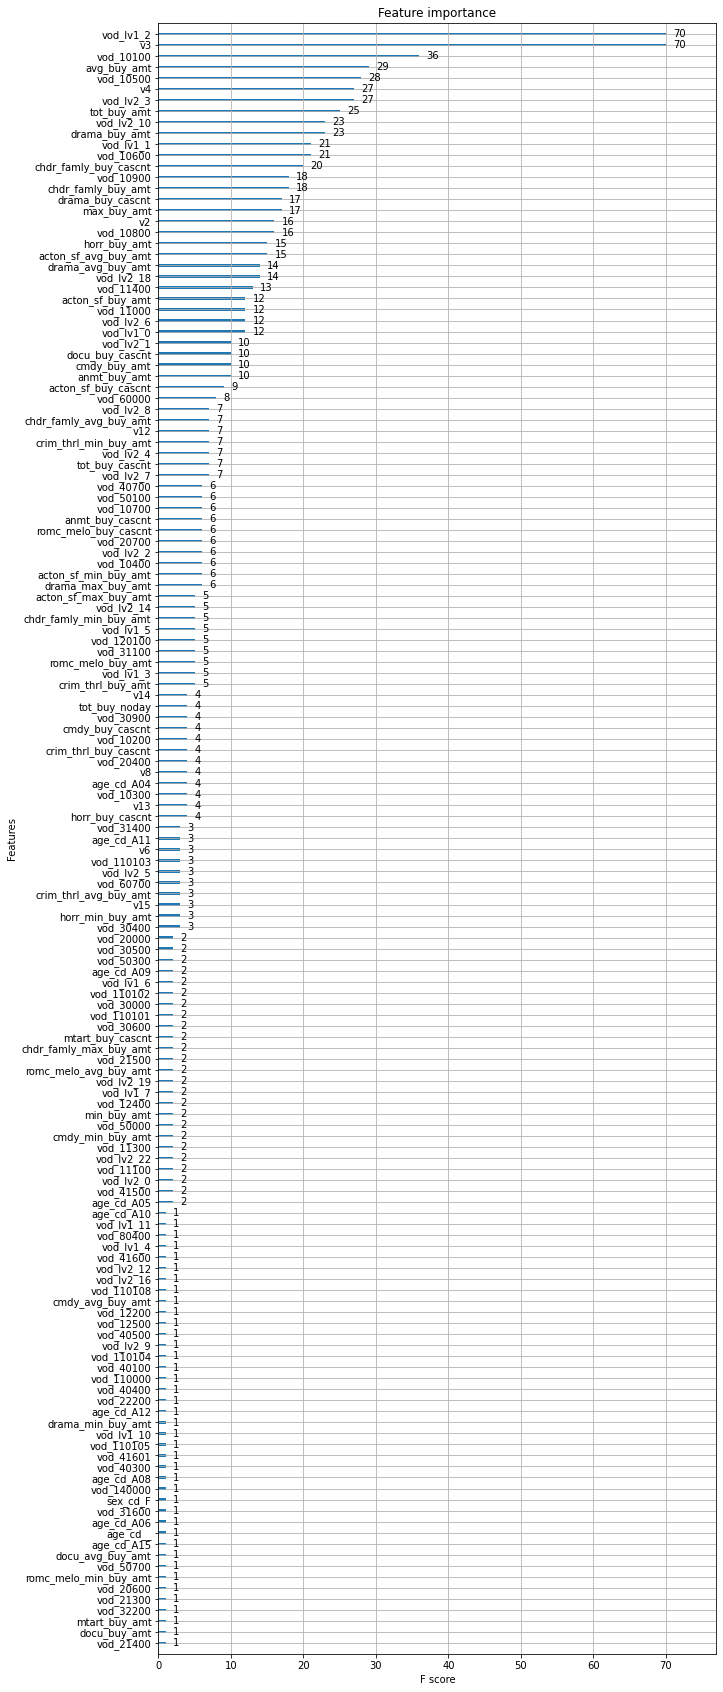

In [54]:
# Importance plot
fig, ax = plt.subplots(figsize=(10,30))
xgb.plot_importance(grid_result.best_estimator_, ax=ax)
ax.figure.savefig('xbg_importance.png')

In [55]:
### Best 모델
xgb_best = grid_result.best_estimator_
print('== Best model:',xgb_best)

# Best 모델을 이용하여 Prediction
test_x_r = test_x_r[train_x_r.columns]
test_probs = xgb_best.predict_proba(test_x_r)
print('== Test prob shape:',test_probs.shape)

== Best model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=15, n_jobs=0, num_class=10, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.3,
              tree_method='exact', validate_parameters=1, verbosity=None)
== Test prob shape: (10000, 10)


In [56]:
### Prediction 결과 확률 값을 담은 DataFrame 생성 
genre = [k for k in e_name_mapping.keys()]

df_test_probs = pd.DataFrame(test_probs, columns=genre)
df_test_probs = pd.concat([test['id'], df_test_probs], axis=1)
df_test_probs

,id,ACTION_SF,ANMT,CHDR_FAMLY,CMDY,CRIM_THRL,DOCU,DRAMA,HORR,MTART,ROMC_MELO
0,E3030346,0.262664,0.087754,0.117544,0.055002,0.102638,0.058523,0.134988,0.067065,0.043564,0.070259
1,E3030347,0.205346,0.252706,0.170402,0.052375,0.056865,0.053279,0.057322,0.051138,0.042227,0.058340
2,E3030348,0.120492,0.093874,0.071039,0.150461,0.153852,0.067006,0.111754,0.095494,0.049970,0.086058
3,E3030349,0.329984,0.080746,0.059799,0.085194,0.074637,0.056493,0.111110,0.080384,0.042410,0.079244
4,E3030350,0.156735,0.252606,0.113805,0.089662,0.084005,0.075069,0.062563,0.057398,0.043973,0.064184
...,...,...,...,...,...,...,...,...,...,...,...
9995,E3040365,0.281930,0.094045,0.062509,0.107276,0.102968,0.056492,0.094213,0.078691,0.042477,0.079398
9996,E3040366,0.331167,0.088296,0.062634,0.080246,0.074905,0.060706,0.099080,0.078849,0.042826,0.081291
9997,E3040367,0.284275,0.058907,0.058594,0.095282,0.108483,0.047410,0.124012,0.114656,0.039135,0.069246
9998,E3040368,0.125878,0.099238,0.076671,0.101838,0.130071,0.073401,0.129265,0.103065,0.054266,0.106307


In [57]:
### top3 DataFrame 생성
result = pd.DataFrame(columns=['id','top1','top2','top3'])
result['id'] = test['id']
col = df_test_probs.columns[1:]

for i,v in df_test_probs.iterrows():
    result.loc[i,['top1','top2','top3']] = col[v.values[1:].argsort()[::-1][:3]]
result

,id,top1,top2,top3
0,E3030346,ACTION_SF,DRAMA,CHDR_FAMLY
1,E3030347,ANMT,ACTION_SF,CHDR_FAMLY
2,E3030348,CRIM_THRL,CMDY,ACTION_SF
3,E3030349,ACTION_SF,DRAMA,CMDY
4,E3030350,ANMT,ACTION_SF,CHDR_FAMLY
...,...,...,...,...
9995,E3040365,ACTION_SF,CMDY,CRIM_THRL
9996,E3040366,ACTION_SF,DRAMA,ANMT
9997,E3040367,ACTION_SF,DRAMA,HORR
9998,E3040368,CRIM_THRL,DRAMA,ACTION_SF


In [58]:
### 저장할 파일명 설정

# 파일 count로 저장
prob_cnt = len([f for f in os.listdir(aidu_framework.config.data_dir) if f.startswith('prob_xgb')]) # directory 안의 파일 수 count
rank_cnt = len([f for f in os.listdir(aidu_framework.config.data_dir) if f.startswith('rank_xgb')]) # directory 안의 파일 수 count
f_pred = '/prob_xgb_' + str(prob_cnt) + '.csv'
f_rank = '/rank_xgb_' + str(rank_cnt) + '.csv'

print('== Probability save to',f_pred)
print('== Output save to',f_rank)

# # ### class 별 확률 저장
# df_test_probs.to_csv(aidu_framework.config.data_dir + f_pred,index=False)
# ### top 1 ~3 저장
# result.to_csv(aidu_framework.config.data_dir + f_rank, header=False, index=False)

== Probability save to /prob_xgb_7.csv
== Output save to /rank_xgb_7.csv


## 3-2. LightGBM

In [59]:
from lightgbm import LGBMClassifier
import datetime
import time
from numpy import mean
from numpy import std

start_time = time.time()

n_fold = 3
seed = 0

# evaluate the model
model = LGBMClassifier(objective='multi:softprob', num_class=10, n_jobs=2)
cv = StratifiedShuffleSplit(train_size = 0.7, test_size=0.3, n_splits = n_fold, random_state = seed)

print("--- Start Time: %s ---" % datetime.datetime.now())
n_scores = cross_val_score(model, train_x_r, train_y_enc, scoring='accuracy', n_jobs=4, cv=cv, verbose=True)
print("--- Running Time: %s seconds ---" % (time.time() - start_time))
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

--- Start Time: 2020-11-06 11:06:14.499290 ---


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:   29.1s finished


--- Running Time: 29.210984706878662 seconds ---
Accuracy: 0.319 (0.002)


In [60]:
# fit the model on the whole dataset
# model = LGBMClassifier()
print("--- Start Time: %s ---" % datetime.datetime.now())
model_fit = model.fit(train_x_r, train_y_enc, verbose=True)
print("--- Running Time: %s seconds ---" % (time.time() - start_time))

--- Start Time: 2020-11-06 11:06:43.716546 ---
--- Running Time: 53.99343156814575 seconds ---


In [61]:
# Return the predicted probability for each class for each sample.
y_predict = model_fit.predict(test_x_r, num_iteration=model.best_iteration_)
# Return the predicted probability for each class for each sample.
y_predict_prob = model_fit.predict_proba(test_x_r, num_iteration=model.best_iteration_)

In [62]:
df_test_probs = pd.DataFrame(y_predict_prob, columns=genre)
df_test_probs = pd.concat([test['id'], df_test_probs], axis=1)
df_test_probs

,id,ACTION_SF,ANMT,CHDR_FAMLY,CMDY,CRIM_THRL,DOCU,DRAMA,HORR,MTART,ROMC_MELO
0,E3030346,0.323233,0.091487,0.153036,0.073210,0.059640,0.048969,0.159488,0.047576,0.004447,0.038913
1,E3030347,0.486654,0.281833,0.136596,0.011956,0.012697,0.013913,0.034495,0.009954,0.004412,0.007490
2,E3030348,0.179234,0.030612,0.032536,0.187599,0.245385,0.037844,0.153979,0.080455,0.002289,0.050067
3,E3030349,0.537976,0.050951,0.059750,0.071912,0.074243,0.054227,0.073680,0.034827,0.002145,0.040289
4,E3030350,0.240167,0.397360,0.114971,0.104614,0.039816,0.016324,0.041058,0.024771,0.006307,0.014614
...,...,...,...,...,...,...,...,...,...,...,...
9995,E3040365,0.318927,0.059821,0.077608,0.164807,0.108552,0.027181,0.113382,0.073174,0.006906,0.049643
9996,E3040366,0.524492,0.029271,0.048094,0.067930,0.055241,0.055893,0.079449,0.076525,0.024832,0.038271
9997,E3040367,0.381248,0.009513,0.004035,0.034087,0.257502,0.003734,0.072541,0.219320,0.000383,0.017638
9998,E3040368,0.098597,0.040652,0.035809,0.215862,0.129243,0.036911,0.232520,0.086986,0.020523,0.102896


In [63]:
### top 1 ~3 DataFrame 생성
result = pd.DataFrame(columns=['id','top1','top2','top3'])
result['id'] = test['id']
col = df_test_probs.columns[1:]

for i,v in df_test_probs.iterrows():
    result.loc[i,['top1','top2','top3']] = col[v.values[1:].argsort()[::-1][:3]]
result

,id,top1,top2,top3
0,E3030346,ACTION_SF,DRAMA,CHDR_FAMLY
1,E3030347,ACTION_SF,ANMT,CHDR_FAMLY
2,E3030348,CRIM_THRL,CMDY,ACTION_SF
3,E3030349,ACTION_SF,CRIM_THRL,DRAMA
4,E3030350,ANMT,ACTION_SF,CHDR_FAMLY
...,...,...,...,...
9995,E3040365,ACTION_SF,CMDY,DRAMA
9996,E3040366,ACTION_SF,DRAMA,HORR
9997,E3040367,ACTION_SF,CRIM_THRL,HORR
9998,E3040368,DRAMA,CMDY,CRIM_THRL


In [64]:
### 저장할 파일명 설정

# 파일 count로 저장
prob_cnt = len([f for f in os.listdir(aidu_framework.config.data_dir) if f.startswith('prob_lgb')]) # directory 안의 파일 수 count
rank_cnt = len([f for f in os.listdir(aidu_framework.config.data_dir) if f.startswith('rank_lgb')]) # directory 안의 파일 수 count
f_pred = '/prob_lgb_' + str(prob_cnt) + '.csv'
f_rank = '/rank_lgb_' + str(rank_cnt) + '.csv'

print('== Probability save to',f_pred)
print('== Output save to',f_rank)

# ### class 별 확률 저장
# df_test_probs.to_csv(aidu_framework.config.data_dir + f_pred, header=False, index=False)
# ### top 1 ~3 저장
# result.to_csv(aidu_framework.config.data_dir + f_rank, header=False, index=False)

== Probability save to /prob_lgb_2.csv
== Output save to /rank_lgb_2.csv


# 4. 앙상블

## 4-1. 모델별 예측 확률의 Weighted average를 통한 Top3 장르 선정

In [73]:
## 예측확률 데이터 로딩

# 모델1
result1 =pd.read_csv(aidu_framework.config.data_dir + '/result1_fin_ez.csv') #AIDU-EZ를 통해 생성한 파일
result1 = result1[result1.columns.tolist()[2:12]]
result1.columns=['_'.join(k.split('_')[3:]) for k in result1.columns]

# 모델2
result2 =pd.read_csv(aidu_framework.config.data_dir + '/ep3_t5_ez_100_1024.csv') #AIDU-EZ를 통해 생성한 파일
result2 = result2[result2.columns.tolist()[2:12]]
result2.columns=['_'.join(k.split('_')[3:]) for k in result2.columns]

# 모델3
category=['ACTION_SF', 'ANMT', 'CHDR_FAMLY', 'CMDY', 'CRIM_THRL', 'DOCU', 'DRAMA', 'HORR', 'MTART', 'ROMC_MELO']
result3 =pd.read_csv(aidu_framework.config.data_dir + '/prob_xgb_3.csv',header=None)
result3.columns = ['id'] + category

# 모델4
result4 =pd.read_csv(aidu_framework.config.data_dir + '/prob_xgb_6.csv',header=None)
result4.columns = ['id'] + category

# 모델5
result5 =pd.read_csv(aidu_framework.config.data_dir + '/prob_xgb_8.csv',header=None)
result5.columns = ['id'] + category

In [ ]:
# Weighted average
f_prob = pd.DataFrame(columns=['id']+category)
f_prob['id']=result3['id']
w = [.1, .1, .3, .3, .2]
for c in category:
    f_prob[c] = w[0]*result1[c] + w[1]*result2[c] + w[2]*result3[c] + w[3]*result4[c] + w[4]*result5[c]

# Top3 저장
f_rank = pd.DataFrame(columns=['id','top1','top2','top3'])
f_rank['id']=f_prob['id']
col = f_prob.columns[1:] #장르 이름만 저장 
for i,v in f_prob.iterrows():
    f_rank.loc[i,['top1','top2','top3']] = col[v.values[1:].argsort()[::-1][:3]]

## 4-2. 최종 결과 저장 

In [ ]:
# f_rank.to_csv(aidu_framework.config.data_dir + '/aiplay1115_result_ep3.csv',index=False,header=False)